## 0. Introduction

This file contains the description and the code of an analysis around the current most dominant topic of the world: The Corona crisis. It was developed as part of the Udacity education program "Data Scientist". 

**Disclaimer: The entire project and all analysis results MUST NOT be considered as scientifically proven insights about the Corona epidemic. It is a project of an inexperienced student in Data Science and its primary purpose is to 
a) finalize the Udacity Data Science training program, and 
b) to generate some insights about the potential of publicly available data in a world-wide crisis.**

The analysis does follow the "Cross-industry standard process for data mining", in short CRISP-DM process model. Thus the first two chapter of the notebook do contain a summary of "Business Understanding" and "Data Understanding". The further steps of the CRISP-DM model are integrated into each of the 5 questions (see chapter below.)

## 1. Business Understanding

Over the first few month in 2020, the Covid-19/Corona virus pandemic has put the entire world into a serious health, social and economic crisis. The pandemic has spread rapidly, and is still spreading rapidly, across all countries. Most countries have closed their borders and shut down their normal societal and economic life.

The Corona pandemic is omnipresent all over the world and many people are working hard to better understand 

1. How quickly the virus spreads across countries and societies,
2. What measures might have an impact on the infection and/or death growth rate, and
3. How dangerous the COVID-19 disease is in comparison to other, past pandemics.

The insights resulting from such analysis could then be used by politicians to take decisions on if and how to either loosen or intensify societal and economical restrictions.

The analysis in this project focusses on the following questions:

1. Which sources of trustful data around the Corona pandemic exists?
2. What kind of data is provided in the various sources and how can it be used to help understand, how fast the virus spreads in a specific country?
3. Are there significant differences between countries in how the pandemic develops? Do these differences justify further research work?
4. How dangerous is COVID-19 disease in comparison to other, past pandemics?


## 2. Data Understanding

The first major challenge of such a project is to identify appropriate and trustworthy data sources. 

After investigation of various publically available sources, I have selected the "European Centre for Disease Prevention and Control" (ECDC) as data provider. The agency provides downloadable data files, which are updated daily and contain the latest available public data on COVID-19.

A detailed discussion of potential data sources is included in the COVID-19 data exploration blog.

### Import libraries and gain some first insights about the provided data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display
from sklearn import preprocessing


The ECDC dataset can be downloaded as CSV file. For this project the data from the 29th of April has been used and stored in the subfolder "data". From there it can be read via the standard Pandas function read_csv.

In [2]:
# Read the ECDC dataset into a Pandas data frame
filename = "data/ECDC_COVID19_20200429.csv"

df_cases = pd.read_csv(filename)

# Show some more information about the data 
df_cases.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,28/04/2020,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
1,27/04/2020,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia
2,26/04/2020,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
3,25/04/2020,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia
4,24/04/2020,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia


The ECDC dataset contains 11 columns:

+ dateRep: Reporting day inlcuding year and month
+ day: Reporting day
+ month: Reporting month
+ year: Reporing year
+ cases: Number of new infections over the last 24h
+ death: Number of new deaths over the last 24h
+ countriesAndTerritories: Name of the country or territory which reported the number
+ geoId: ID of the reporting country
+ countryterritoryCode: Official country code of the reporting country
+ popData2018: Size of the population of the reporting country
+ continentExp: Continent of the reporting country

## Data Preprocessing
### Check the data types and convert as appropriate

In [3]:
# Check imported data types
print("Data Types before conversion:")
print(df_cases.dtypes)

df_cases.dateRep = pd.to_datetime(df_cases.dateRep, format='%d/%m/%Y')


print("\nData Types after conversion:")
print(df_cases.dtypes)

Data Types before conversion:
dateRep                     object
day                          int64
month                        int64
year                         int64
cases                        int64
deaths                       int64
countriesAndTerritories     object
geoId                       object
countryterritoryCode        object
popData2018                float64
continentExp                object
dtype: object

Data Types after conversion:
dateRep                    datetime64[ns]
day                                 int64
month                               int64
year                                int64
cases                               int64
deaths                              int64
countriesAndTerritories            object
geoId                              object
countryterritoryCode               object
popData2018                       float64
continentExp                       object
dtype: object


### Some statistics to verify the data further.

In [4]:
# Number of rows
print("Overall number of rows in the data set: {}\n\n".format(df_cases.shape[0]))

# What are the first and latest reporint days?
print("First reporting day in the data set: {}".format(min(df_cases['dateRep'])))
print("Latest reporting day in the data set: {}\n\n".format(max(df_cases['dateRep'])))

# Number of current total infections and total death?
print("Number of current total infections: {}".format(sum(df_cases['cases'])))
print("Number of current total deaths: {}\n\n".format(sum(df_cases['deaths'])))

# Number of unique countries or territories
print("Number of unique countries or territories within the data set: {}\n\n".format(df_cases.countriesAndTerritories.nunique()))

# Are there any NaN values in the data set?
print("Number of NaN values per column in the data set: {}\n\n".format(df_cases.isna().sum()))


Overall number of rows in the data set: 13623


First reporting day in the data set: 2019-12-31 00:00:00
Latest reporting day in the data set: 2020-04-28 00:00:00


Number of current total infections: 2982688
Number of current total deaths: 210193


Number of unique countries or territories within the data set: 207


Number of NaN values per column in the data set: dateRep                      0
day                          0
month                        0
year                         0
cases                        0
deaths                       0
countriesAndTerritories      0
geoId                       45
countryterritoryCode       152
popData2018                126
continentExp                 0
dtype: int64




Some rows have no geoID, CountryterritoryCode or popData2018. Lets analyse these rows in more detail and adjust as appropriate.

In [5]:
# Show countries and their number of cases / deaths, which do not have a geoID
countries = df_cases[df_cases["geoId"].isnull()]["countriesAndTerritories"].unique()
print("Countries with missing geoId:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

# Show countries and their number of cases / deaths, which do not have a countryterritoryCode
countries = df_cases[df_cases["countryterritoryCode"].isnull()]["countriesAndTerritories"].unique()
print("\nCountries with missing countryterritoryCode:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

# Show countries and their number of cases / deaths, which do not have popData2018
countries = df_cases[df_cases["popData2018"].isnull()]["countriesAndTerritories"].unique()
print("\nCountries with missing popData2018:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

Countries with missing geoId:
	Namibia with 16 cases and 0 deaths.

Countries with missing countryterritoryCode:
	Anguilla with 3 cases and 0 deaths.
	Bonaire, Saint Eustatius and Saba with 6 cases and 0 deaths.
	Cases_on_an_international_conveyance_Japan with 696 cases and 7 deaths.
	Falkland_Islands_(Malvinas) with 13 cases and 0 deaths.
	Western_Sahara with 6 cases and 0 deaths.

Countries with missing popData2018:
	Anguilla with 3 cases and 0 deaths.
	Bonaire, Saint Eustatius and Saba with 6 cases and 0 deaths.
	Eritrea with 39 cases and 0 deaths.
	Falkland_Islands_(Malvinas) with 13 cases and 0 deaths.
	Western_Sahara with 6 cases and 0 deaths.


In [6]:
# Re-sort the data frame along the reporting data
df_cases.sort_values(by=["countriesAndTerritories", "dateRep"],inplace=True)


### Data Understanding Results

Overall, the ECDC dataset contains very "clean" and comprehensive data. More than 200 countries are included with a total of 2 982 688 infections and 210 193 deaths (as of April 28th). There are just a few NaN values, and all of them will most likely not have any major impact on the further analysis.

Therefore we will continue the project based on the selected data set. No further general data preprocessing steps are required.

## Q1: How fast does the pandamic develop within a specific country?

After having identified a trustful data source for the development of infections and deaths, let's see how this data can be used to help understand, how fast the virus spreads in a specific country. For this analysis I have selected Germany as country to be analysed. However, all steps of this analysis can be re-iterated in the same way for any other country.

### Data Preparation & Modeling for Q1

The following KPIs shall be evaluated to determine which KPI, or which combination of KPI's is the best one to answer this question:
+ "Growth Rate": Percentage growth of infections / deaths
  + Calcuated as {number of new cases on day x} / {cumulated number of cases up to day x} * 100
+ "Doubling Days": Number of days in which the number of cases doubles
  + Calculated as {cumulated cases up to day x} / {average number of cases over the last 5 days}
+ "Change of Growth Rate": Change rate of the "Growth Rate"
  + Calculated as {average growth rate of (day x-5 up to day x)} / {average growth rate of (day x-6 up to day x-1)}

In [7]:
# Step 1: Create a subset of the overall data frame that only contains data from the country to be analysed
country_scope = "Germany"
day_of_first_infection = df_cases[df_cases["countriesAndTerritories"]==country_scope]["dateRep"].min()
day_of_first_infection = df_cases[(df_cases["countriesAndTerritories"]==country_scope) & (df_cases["cases"]>0)]["dateRep"].min()
df_country = df_cases[(df_cases["countriesAndTerritories"]==country_scope) & (df_cases["dateRep"]>=day_of_first_infection)].reset_index()
# df_country.set_index("dateRep", inplace=True)

In [8]:
# Day with the highest number of deaths per day
df_country[df_country["deaths"] == df_country["deaths"].max()]

,index,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
79,4861,2020-04-16,16,4,2020,2866,315,Germany,DE,DEU,82927922.0,Europe


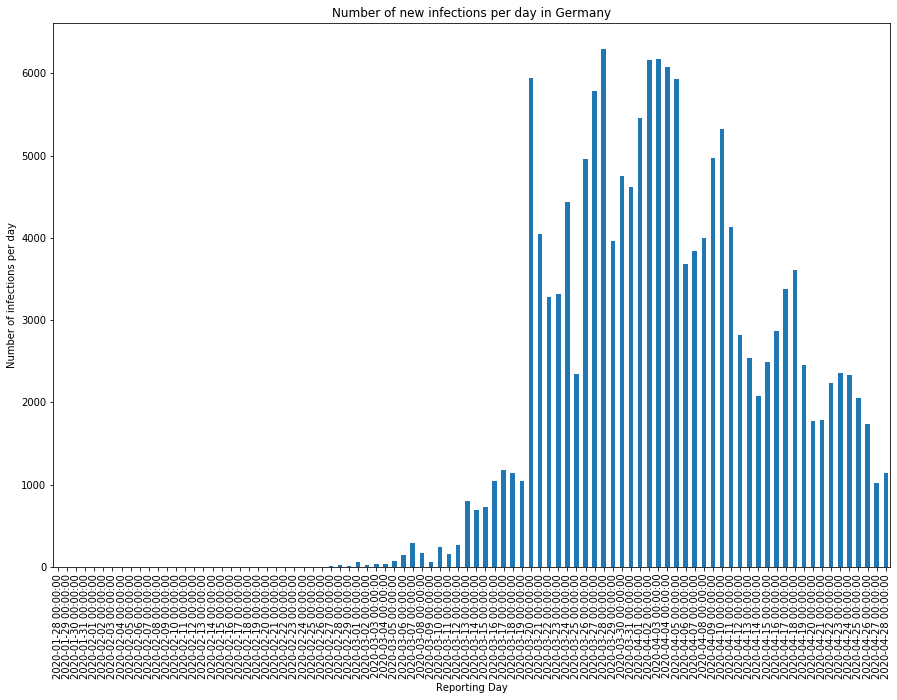

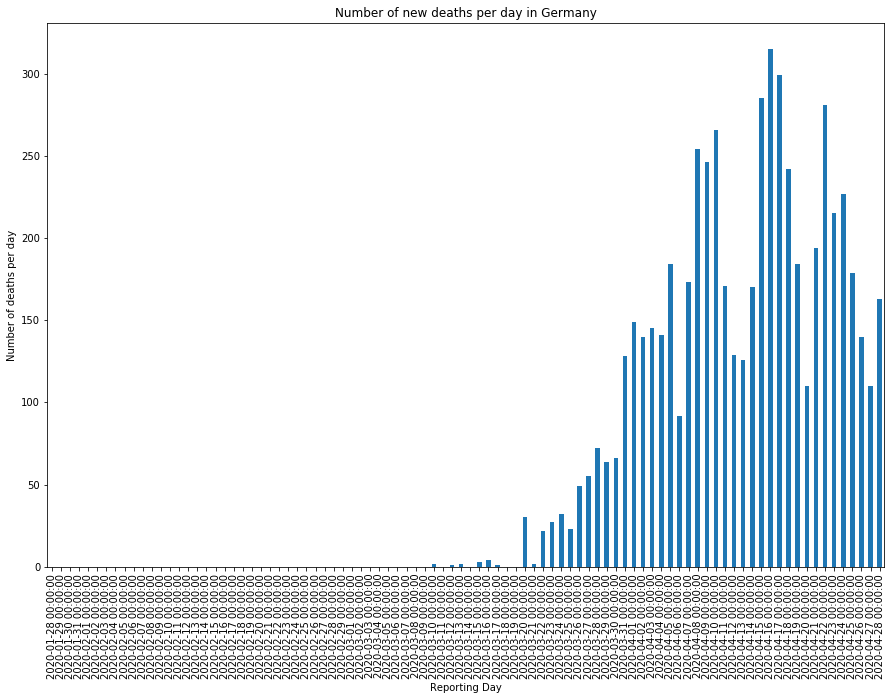

In [9]:
# Step 2: Visualize number of infections and deaths per day

plt.figure(figsize=(15,10))
df_country.set_index("dateRep")["cases"].plot.bar(title="Number of new infections per day in " + country_scope)
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Reporting Day')
plt.ylabel('Number of infections per day')
plt.show()


plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")["deaths"].plot.bar(title="Number of new deaths per day in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Number of deaths per day')
plt.show()

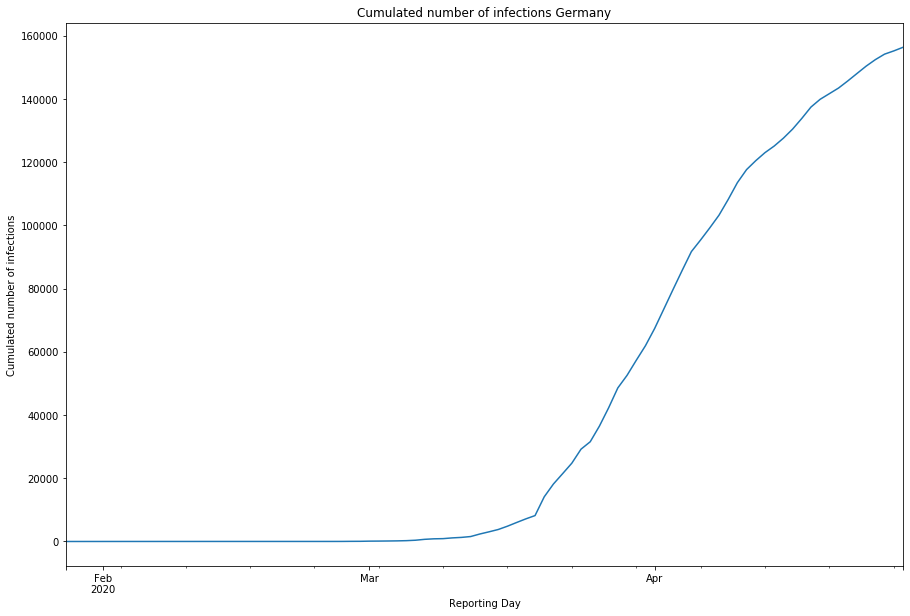

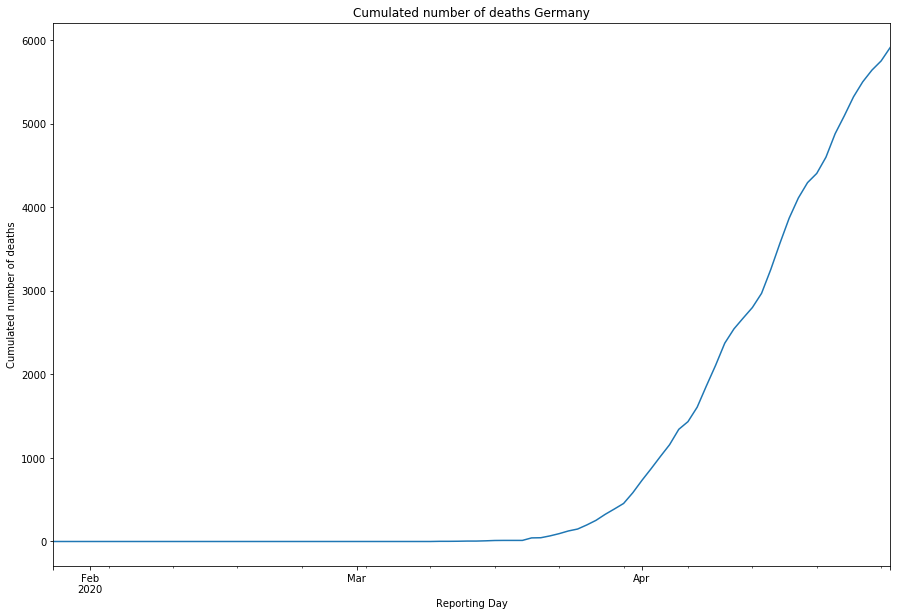

In [10]:
# Step 3: Visualize cumulated number of infections and deaths

# Calculate cumulated sums
df_country[["cum_cases", "cum_deaths"]] = df_country[["cases", "deaths"]].cumsum()

plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")["cum_cases"].plot.line(title="Cumulated number of infections " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Cumulated number of infections')
plt.show()


plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")["cum_deaths"].plot.line(title="Cumulated number of deaths " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Cumulated number of deaths')
plt.show()

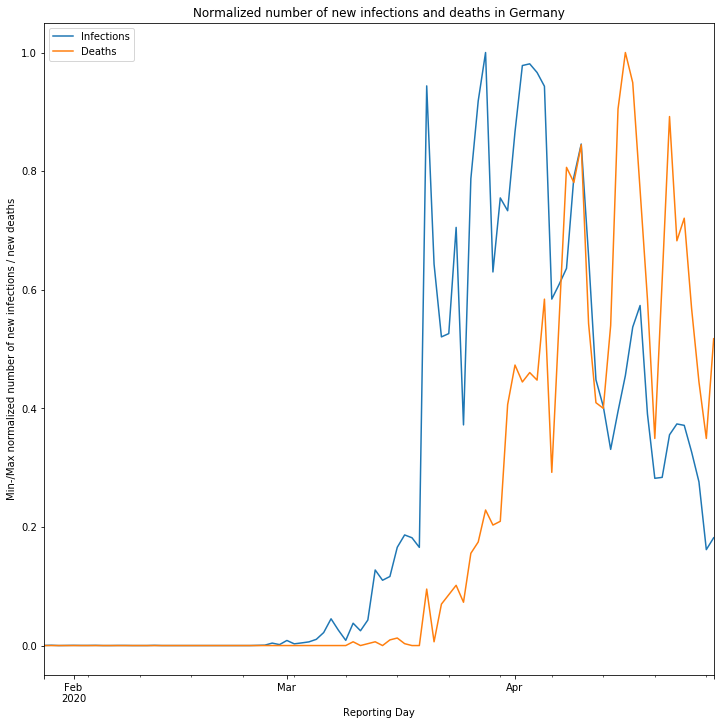

In [11]:
# Step 4: Normalize the numbers of new infections and days and visualize them in one chart

# Normalize the number of infections and the number of deaths using sklearn's preprocessing capabilities
min_max_scaler = preprocessing.MinMaxScaler()
df_country["cases_norm"] = min_max_scaler.fit_transform(df_country["cases"].to_numpy().reshape(-1, 1))
df_country["deaths_norm"] = min_max_scaler.fit_transform(df_country["deaths"].to_numpy().reshape(-1, 1))

# Plot the normalized numbers
plt.rcParams["figure.figsize"] = (12, 12)
df_country.set_index("dateRep")[["cases_norm", "deaths_norm"]].plot.line(title="Normalized number of new infections and deaths in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Min-/Max normalized number of new infections / new deaths')
plt.legend(["Infections", "Deaths"])
plt.show()


### 4. Growth rate an doubling time of new infections / new deahts


Growth rate and "Doubling Time" of new infections are further key measure to assess the speed of a pandemic spread. The formulas are

#### Growth rate
p = (TodayCumulatedNumber - YesterdayCumulatedNumber) / YesterdayCumulatedNumber

 <=> p = DailyNewCases / YesterdayCumulatedNumber

 <=> p = DailyNewCases / (TodayCumulatedNumber - DailyNewCases)

#### Doubling Time
t = Ln(2) / Ln(1+p)

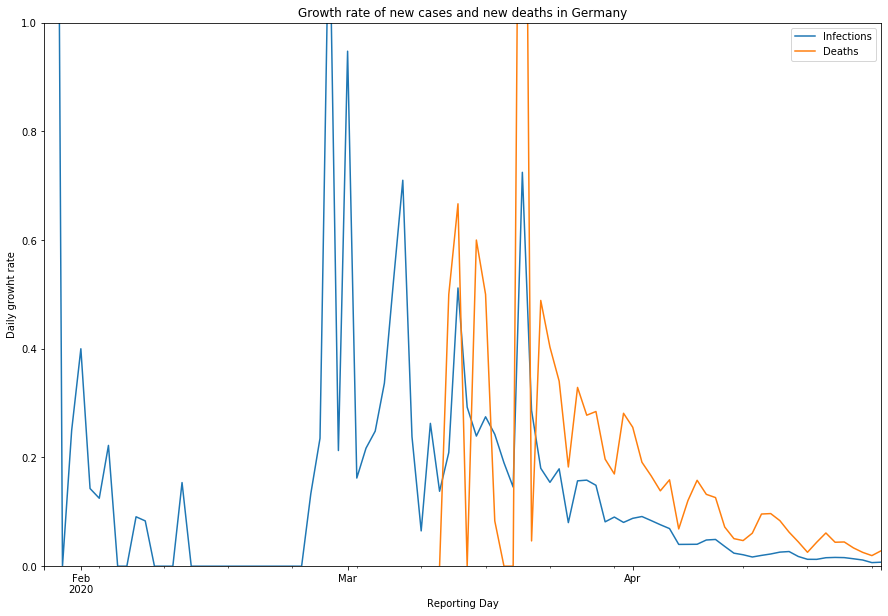

In [12]:
# Step 4.1 Create columns growth_rate_cases and growth_rate_deaths
df_country["growth_rate_cases"] = df_country["cases"] / (df_country["cum_cases"] - df_country["cases"])
df_country["growth_rate_deaths"] = df_country["deaths"] / (df_country["cum_deaths"] - df_country["deaths"])

# Plot the growth rates
plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")[["growth_rate_cases", "growth_rate_deaths"]].plot.line(title="Growth rate of new cases and new deaths in " + country_scope, ylim=(0,1))
plt.xlabel('Reporting Day')
plt.ylabel('Daily growht rate')
plt.legend(["Infections", "Deaths"])
plt.show()

The growth rate of infections does nicely illustrate the exponential growth around end of February until mid of March. In this time frame we can see significant daily growth rates. From mid of March onwards, the growth rate for new infections has flattened significantly.

The growth rate of deaths does follow the growth rate of new infections with around 2 weeks delay.

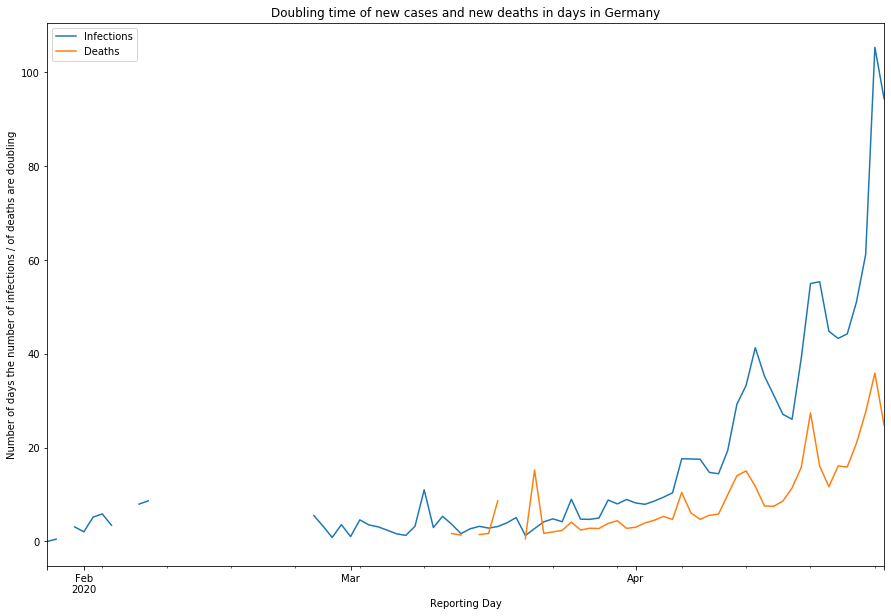

In [13]:
# Step 4.2 Create columns doubling_time_cases and doubling_time_deaths
df_country["doubling_time_cases"] = np.log(2) / np.log(1+(df_country["growth_rate_cases"]))
df_country["doubling_time_deaths"] = np.log(2) / np.log(1+(df_country["growth_rate_deaths"]))

# Plot the doubling times
plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")[["doubling_time_cases", "doubling_time_deaths"]].plot.line(title="Doubling time of new cases and new deaths in days in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Number of days the number of infections / of deaths are doubling')
plt.legend(["Infections", "Deaths"])
plt.show()

The doubling time of new infections was surprisingly stable until mid to end of March. Just by end of March the doubling time started to increase more rapidly and is by now close to 100 days.

The doubling time of new deaths is again following the curve of new infections with around 2 weeks of delay. However, the increase is not yet that significantly.

### Conclusions
The main conclusions out of this second part of the project can be summarized as follows:
1. The publicly available data around the COVID-19 pandemic can be easily used to understand the general dynamics of the pandemic in a single country.
2. At least for Germany, all KPI's from the above sub-chapters indicate that the pandemic development up to know can be structured into 4 phases:
   + *P1 - Warming Up:* The number of new infections per day is at a very low level and stable (4-5 weeks).
   + *P2 - Explosion:* The number of new infections is growing significantly, somehow exploding (1-2 weeks).
   + *P3 - Hot:* The number of new infections varies per day, but seems to be stable overall at a quite high level (3 weeks).
   + *P4 - Cool Down:* The number of new infections declines slowly (x weeks).
3. While all of the KPIs used in this chapter do provide their specific insights, a combination of all does provide the highest value.

## Part III: Analysis of differences in the development of the pandemic between countries
### Intro and Motivation
The COVID-19 pandemic is a world-wide occurrence. And countries are following very different approaches to save lives and not overwhelm healthcare systems. How do these different approach affect the development of the pandemic?


While we have focused on Germany in part II of the project, it makes sense to compare the development of the pandemic between countries in order to 
+ Assess success or failure of the different strategies to cope with the pandemic
+ Identify significant differences as indicator for a root cause analysis
+ Identify common patterns which could help to create more certainty around assumptions about the further development of the pandemic in a specific country.
** Approach
For this analysis we will focus on the following countries:
1. Germany, as we have analyzed Germany already in the chapter before. Germany has reacted quickly to the pandemic, but the measures have not been as restrictive as in Italy or Spain.
2. Italy, as Italy was the first country in Europe with extremely high number of infections and deaths. Italy has reacted not as quickly after the pandemic started in the country, but than put quite restrictive measures in place.
3. USA, as the US is the country with the by far highest number of infections and deaths. The US also reacted rahther late than quickly to the pandemic. The current measure are very different between the various US states.
4. Sweden, as Sweden has taken a very different approach to COVID-19, with significant less restrictive measures than in other countries.
5. UK, as the UK had started with a less restricted approach and then turned to a very rigid approach to tackle COVID-19.

For these 5 countries we will calculate and compare the following KPIs:
+ Development of new infections/deaths in relation to their population size
+ Development of infections/deaths as a percentage of their population size
+ Growth rates and doubling time of new infections/deaths

### KPI 1: Development of new infections/deaths in relation to their population size
#### Purpose and Expectations
This KPI should help us to verify, whether the pandemic develops similar in different countries or whether there are some differences. Based on the observations from part II of this project, in which we have analyzed the development of the pandemic in Germany, and the above briefly outlined different approaches, we could assume:
1. A faster and more significant increase in new cases through the "explosion" phase in Italy, the US and the UK compared to Germany.
2. As the measures in the UK and Italy are more restrict compared to Germany, we could assume that the decrease of new infections/deaths is steeper in those countries.
3. As Sweden is still sticking to the more relaxed approach, I would assume that neither the "explosion" phase nor the "cool down" phase is as steep as in the other countries. This would however not explain, why the more relaxed approach is keeping Sweden in a sufficiently acceptable state with regard to COVID-19 infections and deaths.

#### Data Preparation, Analysis and interim Results

In [14]:
# Step 1: Create a subset of the overall data frame that only contains data from the countries to be analysed
country_scope = ["Germany", "Italy", "United_States_of_America", "Sweden", "United_Kingdom"]
df_countries = df_cases[df_cases["countriesAndTerritories"].isin(country_scope)].reset_index()

# Step 2 Create columns rel_cases and rel_deaths
df_countries["rel_cases"] = df_countries["cases"] / df_countries["popData2018"] * 100
df_countries["rel_deaths"] = df_countries["deaths"] / df_countries["popData2018"] * 100

# Step 3: Pivot the dataset for easier plotting
df_countries_piv_cases = pd.pivot_table(df_countries,index='dateRep',columns='countriesAndTerritories',values="rel_cases").reset_index()
df_countries_piv_deaths = pd.pivot_table(df_countries,index='dateRep',columns='countriesAndTerritories',values="rel_deaths").reset_index()

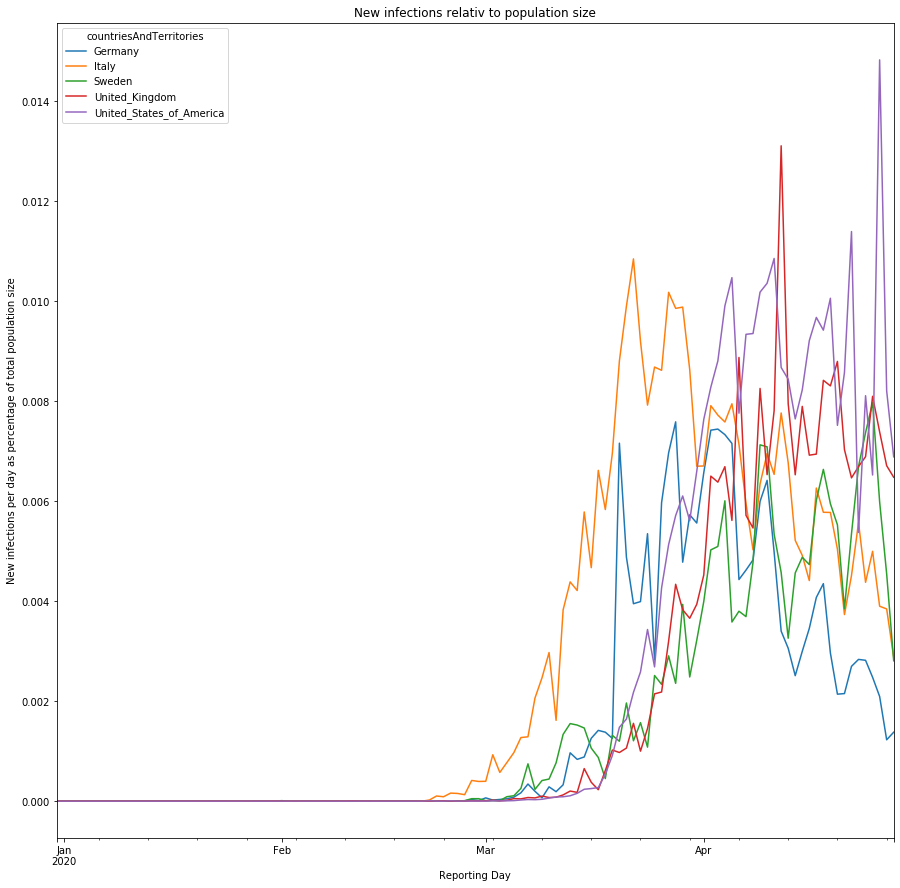

In [15]:
# Step 4: Plot the relativ number of infections from the five countries
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_piv_cases.set_index("dateRep").plot.line(title="New infections relativ to population size")
plt.xlabel('Reporting Day')
plt.ylabel('New infections per day as percentage of total population size')
plt.show()

The graph above does show relevant numbers starting by mid of February. So we adjust the plot and start with Feb 15th.

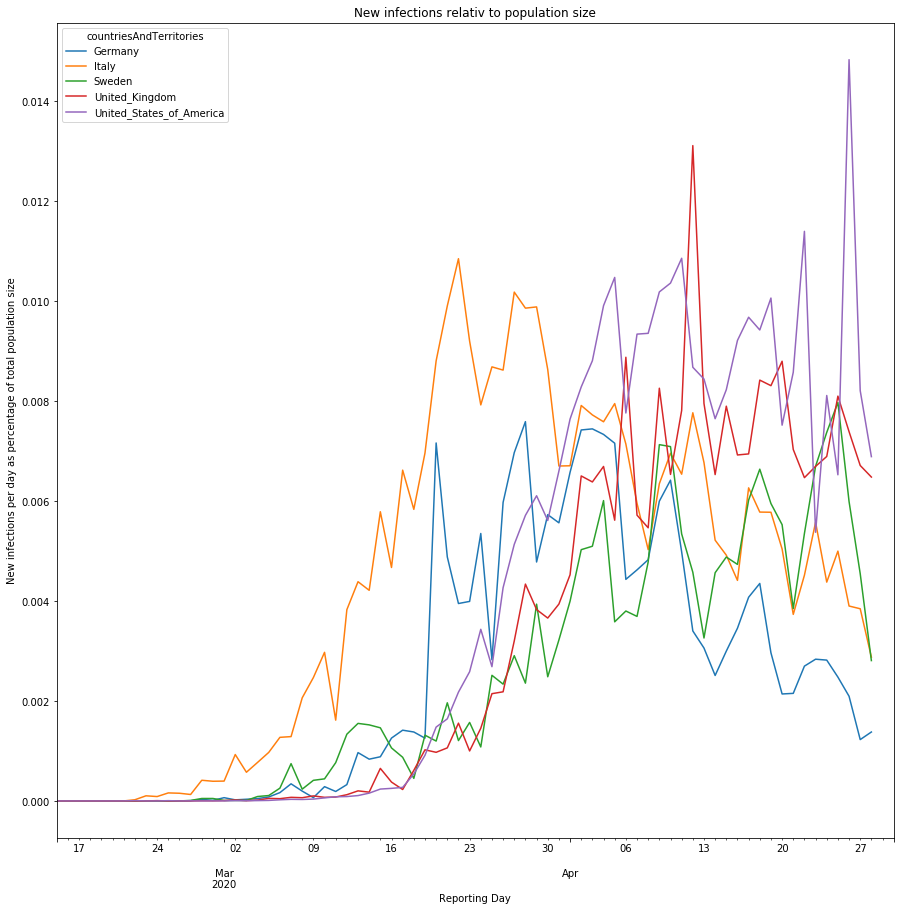

In [16]:
# Step 4.2: Plot the relativ number of infections from the five countries starting with Feb 15th
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_piv_cases.set_index("dateRep").plot.line(title="New infections relativ to population size", xlim=("2020-02-15","2020-04-30"))
plt.xlabel('Reporting Day')
plt.ylabel('New infections per day as percentage of total population size')
plt.show()

Out of this analysis we may derive the subsequent observations. Before, we must make ourselves aware that this analysis was limited to five countries only and that each country might have quite different approaches for COVID-19 testing and reporting. Therefore, while the below conclusions are logically derived from the available data, they are still weak and would need much more analysis before taking final conclusions.
1. Out of the 5 countries, Italy was the one where the pandemic started the earliest. That might explain why it was most difficult for Italy to decide about the appropriate measures as Italy was lacking data from other countries.
2. The significant increase of the pandemic in the other countries started around 2 weeks after Italy. Thus all other 4 countries had at least Italy to learn from.
3. Germany established its "lock-down" measure around mid of March for a period of at least 4 weeks. Even though Germany did face a significant increase of infections in the 2nd half of March, the measures seem to have paid of. The relative number of new infections declined in April and is by now the lowest of the 5 countries.
4. In Sweden, the pandemic grew at the beginning much slower compared to Germany or Italy. That might help to explain why Sweden decided to follow a more relaxed approach. However, as a consequence, the relative number of new infections is not yet declining. As of today the relative numbers are above Germany and around the level of Italy.
5. Similar to Sweden, the pandemic started slower and later in the UK. And at the beginning, also the UK followed a more relaxed approach. However and in contrast to Sweden, the development of the pandemic was much steeper around early April, which forced the UK to change its approach to a more restrictive one. By now, the UK still has 2nd highest new infection rate.
6. Up to mid of March, the COVID-19 pandemic in the US was relatively mild. Over the 2nd half of March the pandemic than increased in a similar way as in Italy. Also the US reacted quite late with mitigation measures and the relative infection rate is still at a comparable high level (highest in the analyzed country group).

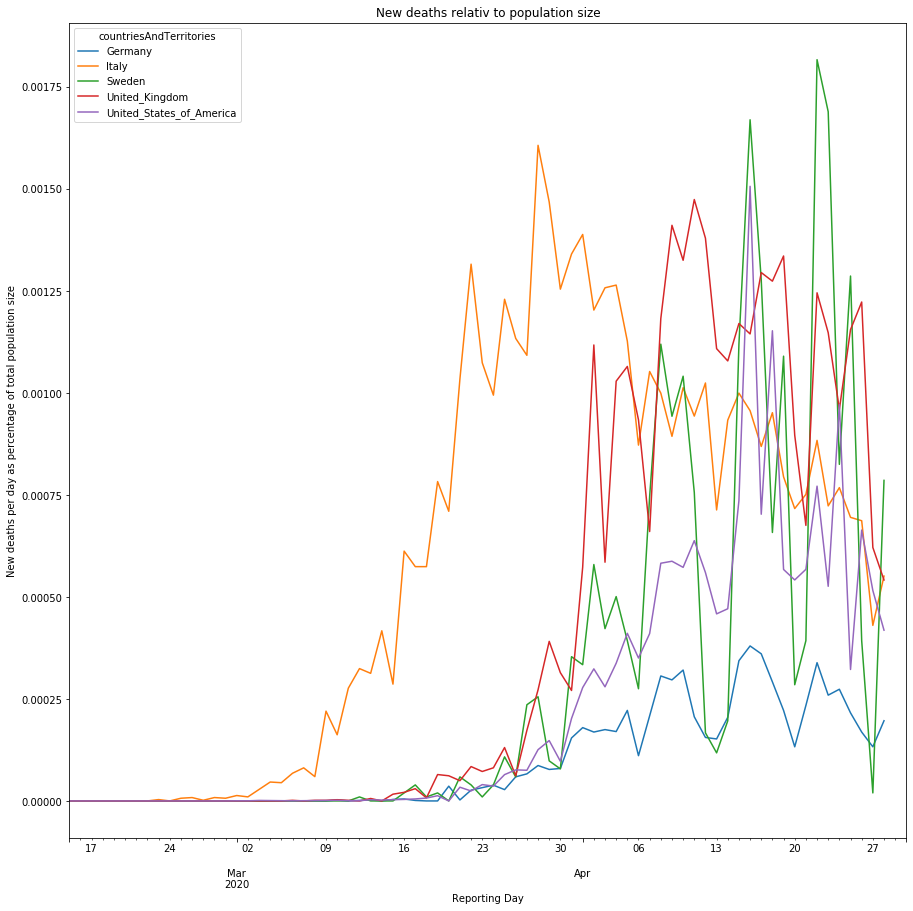

In [17]:
# Step 4.2: Plot the relativ number of deaths from the five countries starting with Feb 15th
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_piv_deaths.set_index("dateRep").plot.line(title="New deaths relativ to population size", xlim=("2020-02-15","2020-04-30"))
plt.xlabel('Reporting Day')
plt.ylabel('New deaths per day as percentage of total population size')
plt.show()

The analysis of the relative number of deaths caused by COVID-19 does provide some additional interesting observations:
1. Compared to the other countries, the relative number of new deaths per day in Germany is the lowest over the entire time-frame. Whether that is due to a "better" healthcare system or other conditions cannot be derived out of the available data.
2. Within the 5 countries, Italy was the one where the deadly impact of the pandemic started the earliest. That might explain why Italy than had to put in place very rigid restriction measures. 
3. Compared to Germany, the development of deaths in all of the three other countries (US, UK and Sweden) was steeper, and is still at a significantly higher level. The rather late, or less restrictive measures in these countries might have ultimately also led to a higher relative number of COVID-19 deaths.
4. The relative death rate in Sweden is comparable high and does currently not indicate to decline. That may increase the pressure on Swedish authorities to adjust their current quite relaxed approach.

#### Conclusions
In our analysis we have been able to observe that the pandemic develops quite differently in countries with different strategies to tackle COVID-19. A fast and consequent reaction with restrictive measures seems to have a positive influence on limiting the number of COVID-19 infections and deaths. 

Approaches with a more relaxed reaction have not paid out in some countries. The data proves that the development of infections / deaths in the UK as well as the US was significantly higher compared to Germany. That might have forced those countries to change their approaches.

Sweden is the country in our analysis which still pursues a more relaxed strategy. Based on the available data, the relative number of infections and deaths stabilized on a comparable high level and so far the numbers are not declining as in the other countries. Depending on the further development, Sweden might get under pressure to change their strategy.

*Overall:* 

The development of the pandemic differs significantly between the countries. Why these differences exist cannot be fully analyzed in this project, but is definitely worth further research. 

We also have not looked into the impacts that the different country strategies and measures have on other aspects like economy and society overall. Therefore it is not possible and I don't want to judge on "better" or "worse" on any of the country strategies from an overall perspective. 

### KPI 2: Development of cumulated infections/deaths as a percentage of their population size

#### Purpose and Expectations
This KPI shall help to understand how far, and how fast the pandemic advanced in the five countries. 

From our analysis so far we might assume that 
+ Germany has the lowest overall rate of COVID-19 infections/deaths as well as the slowest further increase
+ Italy has the highest overall rate of COIVD-19 deaths and infections, but with a slower further increase
+ The development of COIVD-19 infection/deaths is continuing
+ For the UK and the US we might see a similar development

#### Data Preparation, Analysis and interim Results

In [18]:
# Step 0: Create a subset of the overall data frame that only contains data from the countries to be analysed and re-calculate the relative number of infections and deaths
country_scope = ["Germany", "Italy", "United_States_of_America", "Sweden", "United_Kingdom"]

df_countries = df_cases[df_cases["countriesAndTerritories"].isin(country_scope)].reset_index()

df_countries["rel_cases"] = df_countries["cases"] / df_countries["popData2018"] * 100
df_countries["rel_deaths"] = df_countries["deaths"] / df_countries["popData2018"] * 100

# Step 1: Make sure the data is properly sorted by country and date
df_countries = df_countries.sort_values(['countriesAndTerritories','dateRep']).reset_index()


# Step 2: Calcluate two additional columns with cumulative cases and deaths
df_countries_cum = df_countries.copy()

df_countries_cum["cum_rel_cases"] = df_countries_cum.groupby(['countriesAndTerritories', 'dateRep'])["rel_cases"].sum().groupby(level=0).cumsum().reset_index()["rel_cases"]

df_countries_cum["cum_rel_deaths"] = df_countries_cum.groupby(['countriesAndTerritories', 'dateRep'])["rel_deaths"].sum().groupby(level=0).cumsum().reset_index()["rel_deaths"]


# Step 3: Pivot the dataset for easier plotting
df_countries_cum_piv_cases = pd.pivot_table(df_countries_cum,index='dateRep',columns='countriesAndTerritories',values="cum_rel_cases").reset_index()
df_countries_cum_piv_deaths = pd.pivot_table(df_countries_cum,index='dateRep',columns='countriesAndTerritories',values="cum_rel_deaths").reset_index()

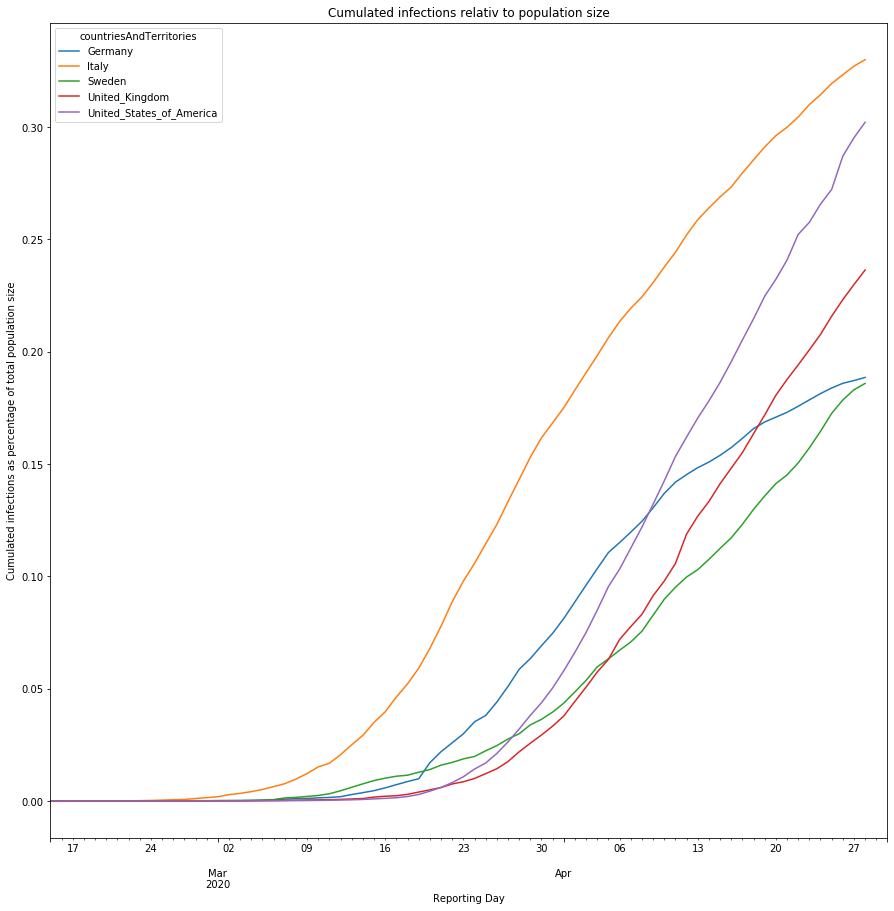

In [19]:
# Step 4.1: Plot the relativ, cumulative number of infections from the five countries starting with Feb 15th
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_cum_piv_cases.set_index("dateRep").plot.line(title="Cumulated infections relativ to population size", xlim=("2020-02-15","2020-04-30"))
plt.xlabel('Reporting Day')
plt.ylabel('Cumulated infections as percentage of total population size')
plt.show()

Overall, the relative number of infections is still far below 1% of the population in all five countries. Whereas the percentage in Sweden and Germany has grown to ~0.18%, the rate is already around 0.3% in Italy and the US. The UK is somehow in between with around 0.25%.

By end of April, the UK and the US have the steepest increase of relative infections, while Germany has the slowest. For Italy the curve is flattening and the US might soon pass by Italy in terms of infections relative to population size.

The development in Sweden was comparable moderate for a long period, but is continuing at a higher speed than e.g. Germany. Sweden might thus soon pass by Germany.

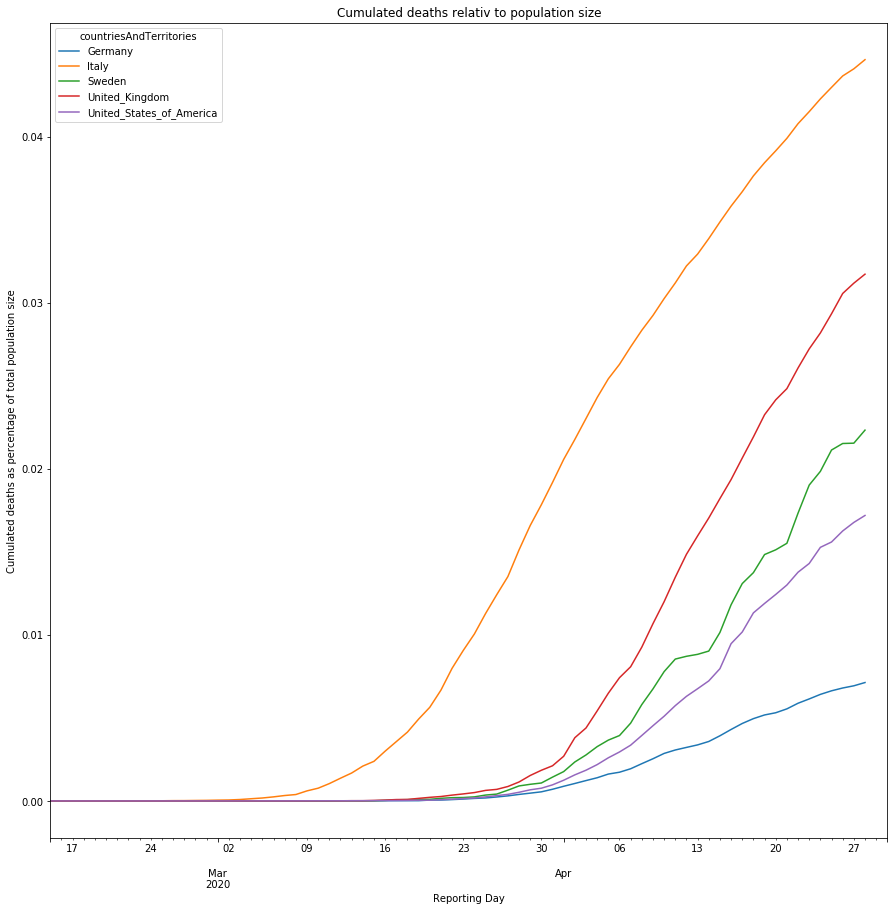

In [20]:
# Step 4.2: Plot the relativ, cumulative number of deaths from the five countries starting with Feb 15th
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_cum_piv_deaths.set_index("dateRep").plot.line(title="Cumulated deaths relativ to population size", xlim=("2020-02-15","2020-04-30"))
plt.xlabel('Reporting Day')
plt.ylabel('Cumulated deaths as percentage of total population size')
plt.show()

The cumulated, relative numbers of deaths show a surprisingly clear picture. Relative to its population size, Italy suffered most with more than 0.04% deaths by end of April. Germany is the only country with less than 0.01% death. The other three countries are in between. 

Also the relative growth rate in Germany is the lowest in the analyzed country group. 

## Part IV: Analysis of the hazardous nature of the COVID-19 pandemic
### Intro and Motivation
Nearly all countries have put extremely rigid COVID-19 mitigation measures in place. Economies are suffering significantly and are likely to fall in the deepest recession since the second world war. Also individual rights have been significantly restricted. Those restrictions might lead to other serious physical and psychological implications, which are not yet visible and/or understood. 

Why are countries establishing such significant measures with such incredible significant implications? To answer this question, we need to understand the hazardous nature of the COVID-19 pandemic.

### Approach
To understand the hazardous nature of COVID-19 we will look at the mortality rate. According to [[https://en.wikipedia.org/wiki/Mortality_rate][Wikipedia]], the mortality rate /"is a measure of the number of deaths (in general, or due to a specific cause) in a particular population, scaled to the size of that population, per unit of time."/

For the purpose of this project, a take a quite simple formula to calculate the mortality rate: <total deaths> / <total infections> per country as of April 28th. Based on this calculation we can 
+ Compare mortality rates between countries
+ Compare COVID-19 mortality rates with mortality rates of past pandemics

A high mortality rate would explain the significance of the COVID-19 mitigation measures that have been put in place by nearly all countries. 
### KPI 1: Mortality Rate per country as of April 28th
In the first analysis we will look at the mortality rate per country as of April 28th. In this analysis we will take the same country group as in Part III of this project.


#### Conclusions
Based on the available data, the COVID-19 pandemic has still only reached a relatively small percentage of the overall population. The number of reported infections is far below 0.5% in all analyzed countries. Even if the real figure of infections is multiple times above the officially reported number, the countries are far away from a sufficient level of infections (60% to 70%) which would stop the further progression of the pandemic.

The data indicates again significant differences between the analyzed countries. With regard to COVID-19 deaths for example, Italy suffered more than 4 times worth compared to Germany. Whatever the reasons are, it seems to be clearly worth to start further research to understand the root causes of these differences.

In [21]:
# Step 0: Create a subset of the overall data frame that only contains data from the countries to be analysed
country_scope = ["Germany", "Italy", "United_States_of_America", "Sweden", "United_Kingdom"]

df_countries = df_cases[df_cases["countriesAndTerritories"].isin(country_scope)].reset_index()


# Step 1: Make sure the data is properly sorted by country and date
df_countries = df_countries.sort_values(['countriesAndTerritories','dateRep']).reset_index()


# Step 2: Calcluate two additional columns with cumulative cases and deaths per country
df_countries_cum = df_countries.copy()

df_countries_cum["cum_cases"] = df_countries_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases"].sum().groupby(level=0).cumsum().reset_index()["cases"]

df_countries_cum["cum_deaths"] = df_countries_cum.groupby(['countriesAndTerritories', 'dateRep'])["deaths"].sum().groupby(level=0).cumsum().reset_index()["deaths"]


# Step 3: Select only the rows with the latest reporting date
df_countries_cum_latest = df_countries_cum[df_countries_cum["dateRep"] == df_countries_cum["dateRep"].max()]


# Step 4: Calculate the mortality rate
df_countries_cum_latest["mortality"] = df_countries_cum_latest["cum_deaths"] / df_countries_cum_latest["cum_cases"] * 100


# Step 5: Sort the dataframe by mortality rate
df_countries_cum_latest.sort_values(by='mortality', inplace=True)


# Step 6: Pivot the dataset for easier plotting
df_countries_cum_latest_piv = pd.pivot_table(df_countries_cum_latest,index='countriesAndTerritories',values="mortality").reset_index()
df_countries_cum_latest_piv.sort_values(by='mortality', inplace=True)


The mortality rates of the analyzed countries do vary significantly around the overall average mortality rate of 7%, which we had calculate already before in part II of the project. Sweden, UK and Italy are around 13%, whereas Germany is at 4% and the US is around 6%. These numbers are all much higher than the COVID-19 mortality rate estimated by the WHO (3.4%). The reason might be the expected high number of infections which are not officially reported and thus are not included in the numbers. On the other side, also not all COVID-19 deaths might be officially reported.

These numbers do again indicate that the pandemic and its health impacts do vary significantly by country. One possible explanation could be the different level and stability of national healthcare systems. But such conclusions are not possible on the data available for this project. Further research based on other data sources would be needed to gain insights on why such huge differences occur.

### KPI 2: Comparing the COVID-19 mortality rate with past pandemics

How dangerous is a COIVD-19 infection compared to other, past pandemics? For that we need visibility on the mortality rates of past pandemics. [Healthline.com](https://www.healthline.com/health-news/how-deadly-is-the-coronavirus-compared-to-past-outbreaks#1918-influenza) does provide such numbers:


| Past Pandemic                   | Death Rate in % |
| ------------------------------- | --------------- |
| Spanish flu from 1918           | 2%              |
| Seasonal flu                    | 0.1%            |
| SARS 2002-2004                  | 15%             |
| H1N1 2009                       | 0.02%           |
| Ebola 2014-2016                 | 50%             |
| WHO estimated COVID-19          | 3.4%            |
| **Calculated average COVID-19** | **7%**          |

Independent from the exact number for the COVID-19 mortality rate, it seems obvious that a COVID-19 infection has a much higher mortality compared to most of the past pandemics. Especially in comparison to the widespread seasonal flue, and even if we trust the WHO estimate more than the available data, the mortality rate of COVID-19 is 34 times
higher compared to seasonal flue.


### Conclusion
Based on the available data, the mortality rate of COVID-19 infections seems to be at least 30 to 40 times above the mortality rate of the regular seasonal flue and quite the double of the Spanish Flue from the early 1900th. The numbers might still be weak due to the quality and comprehensiveness of COVID-19 testing, but there is a clear tendency that COVID-19 is one of the most hazardous infections we have seen over the last centuries. Especially in combination with the possible exponential growth of infections, COVID-19 is extremely dangerous. 

The result of this assessment does well explain the significant level of restrictions that so many countries have put in place.

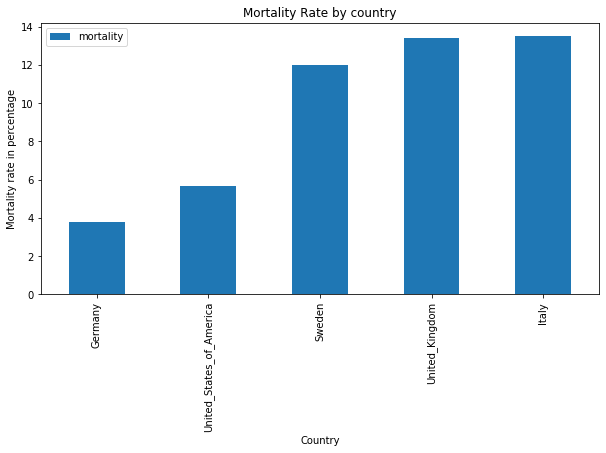

In [22]:
# Step 6: Plot the mortality 
plt.rcParams["figure.figsize"] = (10, 5)
df_countries_cum_latest_piv.set_index("countriesAndTerritories").plot.bar(title="Mortality Rate by country")
plt.xlabel('Country')
plt.ylabel('Mortality rate in percentage')
plt.show()